<a href="https://colab.research.google.com/github/Harshavardhanrajuthonti/NLP/blob/main/NLP_Assignment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torch torchvision matplotlib numpy


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define Encoder and Decoder
class Encoder(nn.Module):
    def __init__(self, latent_dim=2):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim=2):
        super(Decoder, self).__init__()
        self.fc2 = nn.Linear(latent_dim, 400)
        self.fc3 = nn.Linear(400, 28 * 28)

    def forward(self, z):
        z = torch.relu(self.fc2(z))
        z = torch.sigmoid(self.fc3(z))
        return z

class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x.view(-1, 28 * 28))
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

# VAE loss function
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28 * 28), reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_divergence

# Training the VAE
latent_dim = 2
vae = VAE(latent_dim=latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Data loading
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Training loop
epochs = 10
for epoch in range(epochs):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to('cpu')
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_loader.dataset)}")


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 34.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.08MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.7MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.73MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch 1, Loss: 188.76017076822916
Epoch 2, Loss: 166.83615817057293
Epoch 3, Loss: 162.88502890625
Epoch 4, Loss: 160.58211337890626
Epoch 5, Loss: 158.8270716796875
Epoch 6, Loss: 157.44823872070313
Epoch 7, Loss: 156.27592877604167


In [ ]:
# Define the Generator and Discriminator
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        return self.fc(z).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x.view(-1, 28 * 28))

# Initialize generator and discriminator
latent_dim = 100
generator = Generator(latent_dim)
discriminator = Discriminator()

# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

# GAN training loop
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(train_loader):

        # Train Discriminator
        real_imgs = imgs
        optimizer_D.zero_grad()
        real_labels = torch.ones(imgs.size(0), 1)
        fake_labels = torch.zeros(imgs.size(0), 1)
        real_loss = criterion(discriminator(real_imgs), real_labels)
        z = torch.randn(imgs.size(0), latent_dim)
        fake_imgs = generator(z)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        g_loss = criterion(discriminator(fake_imgs), real_labels)
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set the VAE model to evaluation mode
vae.eval()

# Define a 2D grid in the latent space
n = 15  # Number of steps in each axis
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

# Initialize the plot
plt.figure(figsize=(10, 10))

# Loop over each position in the grid and generate the corresponding image
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        # Create a latent vector z with the current position (xi, yi) in the grid
        z = torch.tensor([[xi, yi]], dtype=torch.float32)
        # Ensure z is on the same device as the model (e.g., CPU)
        z = z.to(next(vae.parameters()).device)

        # Decode the latent vector to obtain the corresponding image
        with torch.no_grad():  # Disable gradients for faster and memory-efficient execution
            x_decoded = vae.decoder(z)

        # Convert the output to a NumPy array for plotting
        digit = x_decoded.view(28, 28).cpu().numpy()

        # Plot the generated digit image
        plt.subplot(n, n, i * n + j + 1)
        plt.imshow(digit, cmap="gray")
        plt.axis("off")

# Show the plot
plt.show()



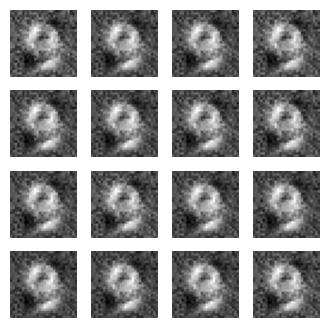

In [ ]:
# Generate new images using the generator
with torch.no_grad():
    z = torch.randn(16, latent_dim)
    fake_images = generator(z).cpu()

# Plot the generated images
plt.figure(figsize=(4, 4))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake_images[i].view(28, 28), cmap="gray")
    plt.axis("off")
plt.show()
